# Init

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from astropy.time import Time
from scipy import interpolate
from matplotlib.colors import LogNorm, SymLogNorm
from scipy.optimize import curve_fit, minimize, least_squares, leastsq
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from scipy.interpolate import interp1d

%matplotlib notebook

# Lensing sims

## load data

In [2]:
porb = 0.099110254908*u.day
semimaj = 0.0450720*const.c*u.s
dpsr = 1.47*u.kpc

In [13]:
relvel = ((psrmass+compmass)/compmass * 2*np.pi*semimaj/porb).to(u.km/u.s) #projected
orbsep = ((psrmass+compmass)/compmass * semimaj).to(u.km) #projected
dlens = (dpsr-orbsep).to(u.kpc)
deff = dlens*dpsr/(dpsr-dlens)

In [14]:
dm, dm_err = np.load('paper_figures/dm.npy') * u.pc/u.cm**3
tau, tau_err = np.load('paper_figures/tau.npy') * u.us
amps, amps_err = np.load('paper_figures/amps.npy')
freqs = np.load('paper_figures/freqs.npy') * u.MHz
T = np.load('paper_figures/times.npy')

xtime = Time(T, format='mjd')
xtime = (xtime-xtime[0]).to(u.min)

amps_avg = np.zeros_like(dm.value)
# amps_avg2 = np.average(amps[0],weights=1/amps[1]**2,axis=-1) #the average shouldn't be weighted by the error, check this
amps_avg = np.average(amps,axis=-1)
amps_avg_err = 1/np.sqrt(np.nansum(1/amps_err**2,axis=1))


#fit cos to amps
fitrange = np.concatenate((np.arange(50),np.arange(100,200),np.arange(320,xtime.size)))
popt, pcov = curve_fit(lambda x, *p: p[0]*np.cos(p[1]*x+p[2])+p[3],xtime.value[fitrange], amps_avg[fitrange], p0=[0.1,1/10,35,0])

#magnification
mag = amps_avg/(popt[0]*np.cos(popt[1]*xtime.value+popt[2])+popt[3])

In [15]:
Effelsberg = EarthLocation(4033949.5*u.m, 486989.4*u.m, 4900430.8*u.m)
source = SkyCoord.from_name('PSRJ2051-0827')
Tlocal = Time(T, format='mjd', scale='utc', location=Effelsberg)
ltt_bary = Tlocal.light_travel_time(source)
Tbary = Tlocal + ltt_bary# Take PB and T) from your favourite ephemeris
PB = 0.099110254345457141828  
T0 = 56579.891145107295671
orbphase = ((Tbary.mjd - T0) % PB) / PB
orbphase[orbphase > 0.5] -= 1

## init functions

In [3]:
def powerlaw(x, *p):
    return p[0]*(x**2+p[2]**2)**(-p[1]/2)#+p[3]
def costf(p, pw, k):
    return np.sum(pw/(powerlaw(k.value,p[0],p[1],p[2],0)) + np.log(powerlaw(k.value,p[0],p[1],p[2],0)))
def powerlaw_fit(k, powspec, pguess = [5e-12, 2, 4e-13]):
    mle = minimize(costf, x0=pguess, args=(powspec[powspec >=0][1:], k[powspec>=0][1:]), method='Nelder-Mead')
    return mle.x

def cen_diff_mat(x):
    D = np.zeros((x.size,x.size))
    for i in range(1,D.shape[0]-1):
        D[i] = np.concatenate(([-1,0,1],D[i][3:]))/(x[i+1]-x[i-1])
        D[i] = np.roll(D[i],i-1)
    D[0] = np.concatenate(([-1,1],(np.zeros(D[0].size-2))))/(x[1]-x[0])
    D[-1] = np.concatenate((np.zeros(D[-1].size-2),[-1,1]))/(x[-1]-x[-2])
    D = D*1/x.unit
    return D

def cen_diff_mat_2(x):
    D = np.zeros((x.size,x.size))
    for i in range(1,D.shape[0]-1):
        a =  2 / ((x[i+1]-x[i])*(x[i+1]-x[i-1]))
        b = -2 / ((x[i+1]-x[i])*(x[i]-x[i-1]))
        c =  2 / ((x[i]-x[i-1])*(x[i+1]-x[i-1]))
        D[i] = np.concatenate(([a.value,b.value,c.value],D[i][3:]))
        D[i] = np.roll(D[i],i-1)
    #edge effect terrible but who cares
    D[0] = D[1]
    D[-1] = D[-2]
    D = D*1/x.unit**2
    return D


def cen_diff_mat_25(x):
    dx = (x[1]-x[0])
    D = np.zeros((x.size,x.size))
    for i in range(2,D.shape[0]-2):
        D[i] = np.concatenate(([-1,16,-30,16,-1],D[i][5:]))
        D[i] = np.roll(D[i],i-2)
    D[0] = np.concatenate(([35,-104,114,-56,11],(np.zeros(D[0].size-5))))
    D[1] = np.concatenate(([11,-20,6,4,-1],(np.zeros(D[0].size-5))))
    D[-2] = np.concatenate((np.zeros(D[-1].size-5),[-1,4,6,-20,11]))
    D[-1] = np.concatenate((np.zeros(D[-1].size-5),[11,-56,114,-104,35]))
    D = D/(12*dx**2)
    return D

In [4]:
def wiener_filter(x, data, data_err, data_mask, nder = 0):
    unit_temp = data.unit
    
    k = np.fft.rfftfreq(data.size,d=x[1]-x[0])
    data_f = np.fft.rfft(data)
    data_mask_f = np.fft.rfft(data_mask)

    data_ps = (data_f.real**2+data_f.imag**2) / data.size
    data_mask_ps = (data_mask_f.real**2+data_mask_f.imag**2) / data_mask.size

    data_ps_corrected = np.fft.rfft(np.fft.irfft(data_ps)/np.fft.irfft(data_mask_ps)).real
    
    params = powerlaw_fit(k, data_ps_corrected.value)
    
    Sf = powerlaw(k.value, params[0], params[1], params[2])
    Sf[0] = 0
    S = np.fft.irfft(Sf)
    S = np.fromfunction(lambda i,j: S[np.abs(i-j)], (len(S),len(S)), dtype=int)
    S = S*data.unit**2

    N = data_err**2
    N = np.diag(N)
    H = np.diag(data_mask)
    
    if nder == 0:
        D = np.eye(x.size)
    else:
        der_unit = cen_diff_mat(x).unit
        D = np.linalg.matrix_power(cen_diff_mat(x), nder) * der_unit**(nder-1)

    W = D @ (S @ H.T) @ np.linalg.inv(H @ S @ H.T + N)
    data_W = W @ data
    
    errsq = D@S@D.T - (W @ H @ S @ D.T).T - W @ H @ S @ D.T + W @ (H @ S @ H.T + N) @ W.T
    data_err_W = np.sqrt(np.diag(errsq))*unit_temp
    
    return x, data_W, data_err_W, data_ps_corrected

In [18]:
def der_filter(x, data, data_err, data_mask, nder = 0):
    unit_temp = data.unit
    
    k = np.fft.rfftfreq(data.size,d=x[1]-x[0])
    data_f = np.fft.rfft(data)
    data_mask_f = np.fft.rfft(data_mask)

    data_ps = (data_f.real**2+data_f.imag**2) / data.size
    data_mask_ps = (data_mask_f.real**2+data_mask_f.imag**2) / data_mask.size

    data_ps_corrected = np.fft.rfft(np.fft.irfft(data_ps)/np.fft.irfft(data_mask_ps)).real
    
#     params = powerlaw_fit(k, data_ps_corrected.value)
    
#     Sf = powerlaw(k.value, params[0], params[1], params[2])
#     Sf[0] = 0
#     S = np.fft.irfft(Sf)
    S = np.fft.irfft(data_ps_corrected)
    S = np.fromfunction(lambda i,j: S[np.abs(i-j)], (len(S),len(S)), dtype=int)
#     S = S*data.unit**2
    
#     S = Cdm2 * (data.unit)**2

    N = data_err**2
    N = np.diag(N)
    H = np.eye(data.size)
    
    if nder == 0:
        D = np.eye(x.size) * u.dimensionless_unscaled
    elif nder == 1:
#         der_unit = cen_diff_mat(x).unit
        D = cen_diff_mat(x)# * der_unit**(1)
    elif nder == 2:
#         der_unit = cen_diff_mat_2(x).unit
        D = cen_diff_mat_2(x)# * der_unit
    else:
        print('not compatible derivative order')
        return

#     print(D.shape,S.shape,H.shape,N.shape)
    
    W = D @ (S @ H.T) @ np.linalg.inv(H @ S @ H.T + N)
    data_W = W @ data
    
    errsq = D@S@D.T - (W @ H @ S @ D.T).T - W @ H @ S @ D.T + W @ (H @ S @ H.T + N) @ W.T
    data_err_W = np.sqrt(np.diag(errsq))#*unit_temp
    
    return x, data_W, data_err_W#, data_ps_corrected

In [1]:
def dm_to_lensing(time, dm, dm_err, dm_mask, freq, dpsr, dlens, v_proper, angle, N, max_img_num=-1):
    
    
    """
    Inputs: everything should have units except dm_mask and N
    time: time axis
    dm: dm
    dm_err: error on dm
    dm_mask: boolean array same size as DM, 0 if missing DM, 1 otherwise
    freq: frequency to compute
    dpsr: earth-pulsar distance
    dlens: earth-lens distance
    v_proper: proper velocity
    angle: proper-motion/lens angle
    N: output arrays length
    max_img_num: maximum number of images expected (used to allocate arrays) default=-1 will try to guess
    
    Output:
    nimages: number of images at each position, array size N
    beta_indep: beta as an independent variable, array size N
    tnew: output time axis with same format as input time, astropy time array size N
    im_pos_beta: beta of each image, array size (N,max(nimages))
    im_pos_theta: theta of each image, array size (N,max(nimages))
    im_delay: delay of each image relative to image 0, array size (N,max(nimages))
    im_delay_los: delay of each image relative to beta, array size (N,max(nimages))
    im_mu: magnification of each image, array size (N,max(nimages))
    """
    
    
    #use k_DM here instead
    re = const.a0 * const.alpha**2
    # remove mean
#     dm -= dm.mean()

    # make it even
    if time.size%2 == 1:
        time = time[1:]
        dm = dm[1:]
        dm_err = dm_err[1:]
        dm_mask = dm_mask[1:]
    
    tformat = time.format
    time = time.mjd * u.day
    time_centered = time-np.median(time)
    
    v_T = v_proper * np.cos(angle)
    
    x_lens = (time_centered*v_T*dlens).to(u.au, equivalencies=u.dimensionless_angles())
    
    phi = (dm*re*(const.c/freq)).to(u.Mrad, equivalencies=u.dimensionless_angles())
    dphi = (dm_err*re*(const.c/freq)).to(u.Mrad, equivalencies=u.dimensionless_angles())
    
    x_lens, phi_0, dphi_0 = der_filter(x_lens,phi,dphi,dm_mask,nder=0)
    x_lens, phi_1, dphi_1 = der_filter(x_lens,phi,dphi,dm_mask,nder=1)
    x_lens, phi_2, dphi_2 = der_filter(x_lens,phi,dphi,dm_mask,nder=2)
    
    theta = (x_lens/dlens).to(u.dimensionless_unscaled, equivalencies=u.dimensionless_angles())
    s = (1-dlens/dpsr)
    alpha = (phi_1*(const.c/freq)/(2*np.pi)).to(u.dimensionless_unscaled, equivalencies=u.dimensionless_angles())
    beta = (theta - s*alpha).to(u.dimensionless_unscaled, equivalencies=u.dimensionless_angles())
    mu = 1/(np.gradient(beta,theta))
#     mu = 1/(1-s*(const.c/freq)/(2*np.pi)*phi_2).to(u.dimensionless_unscaled, equivalencies=u.dimensionless_angles())
 
    theta = theta.to(u.mas, equivalencies=u.dimensionless_angles())
    alpha = alpha.to(u.mas, equivalencies=u.dimensionless_angles())
    beta = beta.to(u.mas, equivalencies=u.dimensionless_angles())
    
    dalpha = (dphi_1*(const.c/freq)/(2*np.pi)).to(u.mas, equivalencies=u.dimensionless_angles())
    dbeta = s*dalpha
    
    beta_interp = interp1d(theta,beta,'quadratic')
    beta_indep = beta_interp(np.linspace(theta[0],theta[-1],N))

    # first, do a rough scan to see the max number of images so we can initialize the images arrays with the proper dimension
    if max_img_num == -1:
        tck_shift, u_sift = interpolate.splprep([(beta-beta[0]).value, theta.value], s=0, u = theta.value)
        beta_quickscan = np.linspace(beta[0],beta[-1],beta.size*10)
        delta_beta = np.diff(beta_quickscan)[0]
#         max_img_num = 0
        for b in beta_quickscan:
            tck_shift[1][0] -= delta_beta.value
            if len(interpolate.sproot(tck_shift)[0]) > max_img_num:
                max_img_num = len(interpolate.sproot(tck_shift)[0])

    # now, interpolate [beta(theta), theta] as a 1D curve in 2D, then shift to compute image positions
    tck_orig, u_orig = interpolate.splprep([beta.value,theta.value], s=0, u=theta.value)

    # now, interpolate and ray-trace
    tck_shift, u_shift = interpolate.splprep([(beta-beta[0]).value, theta.value], s=0, u=theta.value)
    beta_indep = np.linspace(beta[0],beta[-1],N,endpoint=False)
    delta_beta = np.diff(beta_indep)[0]
    im_pos = np.full((beta_indep.size,max_img_num),np.nan)
    im_mu = np.full((beta_indep.size,max_img_num),np.nan)
    im_delay = np.full((beta_indep.size,max_img_num),np.nan)
    im_delay_los = np.full((beta_indep.size,max_img_num),np.nan)
    for i, b in enumerate(beta_indep):
        tck_shift[1][0] -= delta_beta.value
        if np.size(interpolate.sproot(tck_shift)[0]) > 0:
            for j in range(len(interpolate.sproot(tck_shift)[0])):
                try:
                    im_pos[i,j] = interpolate.sproot(tck_shift)[0][j]
                    im_delay[i,j] = (interpolate.splev(im_pos[i,j],tck_orig)[1] - interpolate.splev(im_pos[i,0],tck_orig)[1])**2
                    im_delay_los[i,j] = (interpolate.splev(im_pos[i,j],tck_orig)[1] - b.value)**2
                    im_mu[i,j] = 1/interpolate.splev(im_pos[i,j],tck_orig,der=1)[0]
                except KeyboardInterrupt:
                    raise
                except:
                    print('error at idx {}, image {}'.format(i,j))
    im_pos_beta = interpolate.splev(im_pos,tck_orig)[0]*u.mas
    im_pos_theta = interpolate.splev(im_pos,tck_orig)[1]*u.mas
    im_delay = im_delay * (u.mas**2*(dlens/s)/(2*const.c)).to(u.ms, equivalencies=u.dimensionless_angles())
    im_delay_los = im_delay_los * (u.mas**2*(dlens/s)/(2*const.c)).to(u.ms, equivalencies=u.dimensionless_angles())
    
    nimages = np.nansum(~np.isnan(im_pos_theta), axis=-1)
  
    if (np.shape(v_proper) == ()) or (np.shape(v_proper) == (1,)):
        v_new = v_proper
    elif np.shape(v_proper) == np.shape(dm):
        v_interp = interp1d(time,v_proper,'quadratic')
        v_new = v_interp(np.linspace(time[0],time[-1],N))*v_proper.unit
    else:
        print('v_proper should be float or array of shape dm.size')
        return
    
    tnew = (beta_indep/(v_new*np.cos(angle))).to(u.day, equivalencies=u.dimensionless_angles())
    tnew += np.median(time)
    tnew = Time(tnew,format=tformat)
    
    return nimages, beta_indep, tnew, im_pos_beta, im_pos_theta, im_delay, im_delay_los, im_mu

## lensing simulation

In [41]:
nimages1f, beta_obs1f, tnew_1f, im_pos_beta1f, im_pos_theta1f, im_delay1f, im_delay_los1f, im_mu1f = dm_to_lensing(
    Time(T, format='mjd'), dm, dm_err, np.ones(dm.size), 1375 * u.MHz,
    dpsr, dlens,
    relvel / dlens, 0 * u.deg, N=5000)

x_sim = np.linspace(xtime[0].value,xtime[-1].value,im_mu1f.shape[0])

In [42]:
print('max number of images: {}'.format(nimages1f.max()))

max number of images: 1


<IPython.core.display.Javascript object>


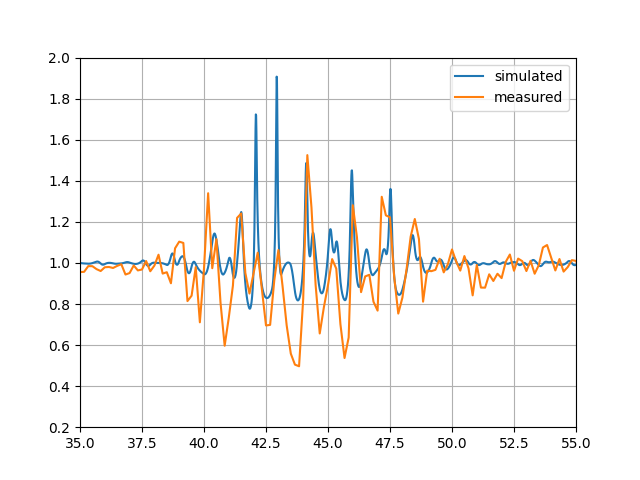

(0.2, 2.0)

In [44]:
plt.figure()
plt.plot((tnew_1f-tnew_1f[0]).to(u.min),im_mu1f[:,0],label='simulated')
plt.plot(xtime,mag,label='measured')
plt.legend()
plt.grid()
plt.xlim(35,55)
plt.ylim(0.2,2)